In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import scipy
from scipy.sparse import csr_matrix, find, hstack,vstack
import gensim
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2

/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [2]:
data_raw = pd.read_csv('df_processed', encoding = 'utf-8')

In [4]:
data_raw.head()

,text,target,clean_text
0,There is no right more basic in our democracy ...,0,right basic democracy participate elect politi...
1,I adhere to the view that this Court’s decisio...,0,adhere view court decision buckley v valeo u p...
2,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",0,nearly years ago buckley v valeo u per curiam ...
3,This case was brought here by an appeal from t...,0,case bring appeal decree circuit court souther...
4,"Plaintiff in error, who was plaintiff below, c...",0,plaintiff error commence action supreme court ...


In [3]:
# vectorize
vectorizer = CountVectorizer(stop_words = 'english', ngram_range =(2,2)) #bi-gram models
X = vectorizer.fit_transform(data_raw['clean_text'])
y = data_raw['target']

In [5]:
data_raw['target'].value_counts() # a clear imbalance between 0 and 1

0    31910
1     2968
Name: target, dtype: int64

In [6]:
# Oversampling
sm = SMOTE(random_state = 811)
X_res, y_res = sm.fit_resample(X, y.ravel())

/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [7]:
X_res.shape, y_res.shape # a lot of features, but let's trim them down :)

((63820, 6096835), (63820,))

In [8]:
# Feature selection
X_best = SelectKBest(chi2, k = 1500).fit_transform(X_res, y_res)

In [13]:
# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X_best, y_res, test_size = 0.2)

In [14]:
# Split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [15]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((45950, 1500), (45950,), (5106, 1500), (5106,))

## Model 1: Support Vector Machine

In [16]:
# Baseline model: SVM
svm = LinearSVC()
svm.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [17]:
preds = svm.predict(X_val)

In [18]:
print(roc_auc_score(preds, y_val))

0.9637324540085133


In [19]:
# tuning hyperparameters for SVM
params = {'C':[1, 10, 100]}
grid = GridSearchCV(svm, param_grid = params, scoring = 'roc_auc')

In [20]:
grid.fit(X_train, y_train)

/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None, param_grid={'C': [1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [21]:
print(grid.best_score_) # best possible ROC AUC score that this model could achieve using the chosen hyperparameters

0.988384483513802


In [22]:
# Let's combine validation data and train data and re-train the model with the tuned hyperparameters
X_train_final = vstack([X_train, X_val]).toarray()
y_train_final = np.hstack((y_train, y_val))

In [23]:
grid.fit(X_train_final, y_train_final)

/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/anhvu/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number o

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None, param_grid={'C': [1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [24]:
preds_svm_final = grid.predict(X_test)

In [25]:
print(roc_auc_score(preds_svm_final, y_test)) # sweet, training and test set performs similarly

0.9624673710777588


## Model 2: MLP

In [26]:
# Model MLP
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
preds_mlp = mlp.predict(X_val)
print(roc_auc_score(preds_mlp, y_val))

0.9734218136572562


In [27]:
mlp.fit(X_train_final, y_train_final)
preds_mlp = mlp.predict(X_test)
print(roc_auc_score(preds_mlp, y_test))

0.9729258414553787


## Deep Learning

In [178]:
# Prepare input for our RNNs
from tensorflow.keras.layers import Flatten
maxlen = 500 # max input length for a feature
max_words = 10000

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(data_raw['clean_text'])

max_features = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(data_raw['clean_text']) 
train = pad_sequences(sequences, maxlen=maxlen)

In [165]:
print(max_features)

117783


In [179]:
X_train, X_test, y_train, y_test = train_test_split(train, data_raw['target'], test_size = 0.2)

In [180]:
X_train.shape, y_train.shape

((27902, 500), (27902,))

In [181]:
# Vanille model
model = Sequential()
model.add(Embedding(10000, 32, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 500, 32)           320000    
_________________________________________________________________
flatten_10 (Flatten)         (None, 16000)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                512032    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 33        
Total params: 832,065
Trainable params: 832,065
Non-trainable params: 0
_________________________________________________________________
Train on 22321 samples, validate on 5581 samples
Epoch 1/10
22321/22321 [==============================] - 5s 241us/sample - loss: 0.1486 - acc: 0.9481 - val_loss: 0.1097 - val_acc: 0.9629
Epoch 2/10
22321/22321 [==============================] 

In [182]:
results = model.evaluate(X_test, y_test, verbose = 0)
print("Loss", results[0], "Accuracy", results[1]) # the model was clearly overfitting

Loss 0.5709790486522018 Accuracy 0.9614392


In [34]:
# Let's try making a LSTM with Glove embedding layer
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [35]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")

(400000, 100)

In [195]:
import os
path = os.getcwd() 
dirname = os.path.join(path, 'glove.6B.100d.txt')

embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Current Directory /Users/anhvu/Own projects
Found 400000 word vectors.


In [36]:
pretrained_weights = glove_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
pretrained_weights.shape

/Users/anhvu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/Users/anhvu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


(400000, 100)

In [196]:
embedding_dim = 100
word_index = tokenizer.word_index

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [197]:
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32, 
    dropout=0.1, recurrent_dropout=0.1, bias_regularizer = l2(0.1)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_44 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
unified_lstm_26 (UnifiedLSTM (None, 32)                17024     
_________________________________________________________________
dense_50 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 1,018,113
Trainable params: 1,018,113
Non-trainable params: 0
_________________________________________________________________


In [199]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [200]:
history = model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data = (X_test, y_test))

W0505 20:59:16.274105 4453322176 training.py:2131] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Train on 27902 samples, validate on 6976 samples
Epoch 1/10
27902/27902 [==============================] - 1058s 38ms/sample - loss: 1.3052 - acc: 0.9473 - val_loss: 0.1812 - val_acc: 0.9573
Epoch 2/10
27902/27902 [==============================] - 1004s 36ms/sample - loss: 0.1320 - acc: 0.9591 - val_loss: 0.1285 - val_acc: 0.9590
Epoch 3/10
27902/27902 [==============================] - 1689s 61ms/sample - loss: 0.1074 - acc: 0.9648 - val_loss: 0.1151 - val_acc: 0.9659
Epoch 4/10
27902/27902 [==============================] - 1891s 68ms/sample - loss: 0.0884 - acc: 0.9699 - val_loss: 0.0932 - val_acc: 0.9688
Epoch 5/10
27902/27902 [==============================] - 1156s 41ms/sample - loss: 0.0787 - acc: 0.9742 - val_loss: 0.0993 - val_acc: 0.9692
Epoch 6/10
27902/27902 [==============================] - 1114s 40ms/sample - loss: 0.0693 - acc: 0.9769 - val_loss: 0.1021 - val_acc: 0.9695
Epoch 7/10
27902/27902 [==============================] - 1147s 41ms/sample - loss: 0.0625 - acc: 0

In [201]:
results_2 = model.evaluate(X_test, y_test, verbose = 0)

In [202]:
print("Loss", results_2[0], "Accuracy", results_2[1]) # the model was clearly overfitting

Loss 0.12158960980414456 Accuracy 0.9701835


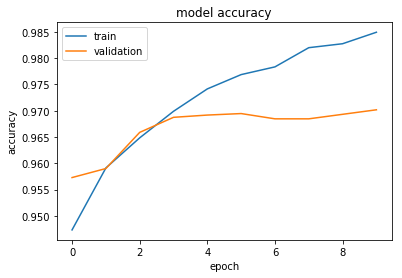

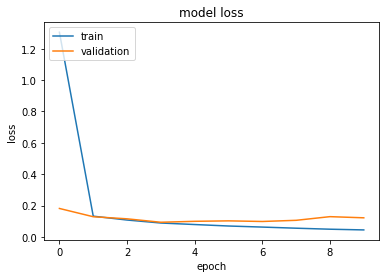

In [203]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()